In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 2000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11493376/11490434 [==============================] - 25s 2us/step


In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.364930, accuracy: 0.914062
step: 200, loss: 0.328402, accuracy: 0.902344
step: 300, loss: 0.220630, accuracy: 0.960938
step: 400, loss: 0.263911, accuracy: 0.910156
step: 500, loss: 0.157943, accuracy: 0.960938
step: 600, loss: 0.131734, accuracy: 0.972656
step: 700, loss: 0.184904, accuracy: 0.964844
step: 800, loss: 0.210520, accuracy: 0.949219
step: 900, loss: 0.126345, accuracy: 0.968750
step: 1000, loss: 0.138483, accuracy: 0.960938
step: 1100, loss: 0.160687, accuracy: 0.957031
step: 1200, loss: 0.170257, accuracy: 0.953125
step: 1300, loss: 0.095284, accuracy: 0.972656
step: 1400, loss: 0.079886, accuracy: 0.980469
step: 1500, loss: 0.100622, accuracy: 0.968750
step: 1600, loss: 0.143513, accuracy: 0.957031
step: 1700, loss: 0.077655, accuracy: 0.988281
step: 1800, loss: 0.076844, accuracy: 0.980469
step: 1900, loss: 0.085124, accuracy: 0.980469
step: 2000, loss: 0.048687, accuracy: 0.996094


In [9]:
# Test model on validation set.
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.964500


In [10]:
# Visualize predictions.
import matplotlib.pyplot as plt

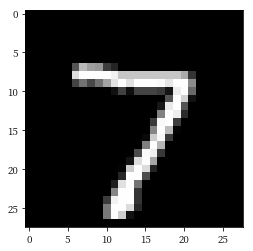

Model prediction: 7


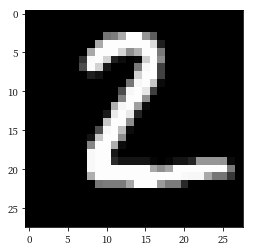

Model prediction: 2


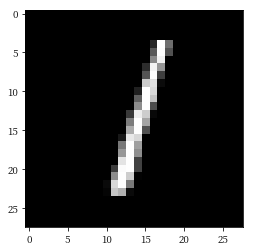

Model prediction: 1


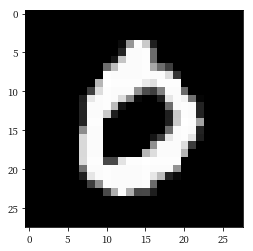

Model prediction: 0


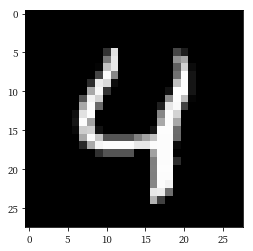

Model prediction: 4


In [11]:

# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))